In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from mxnet import nd, autograd, gluon
import mxnet as mx
from mxnet.gluon import nn, rnn
from mxnet.ndarray.linalg import gemm2
import datetime
from datetime import datetime

In [2]:
def padding(chars, maxlen):
    if len(chars) < maxlen:
        return chars + ' ' * (maxlen - len(chars))
    else:
        return chars[:maxlen]

def gen_date():
    rnd = int(np.random.uniform(low = 1000000000, high = 1350000000))
    timestamp = datetime.fromtimestamp(rnd)
    return str(timestamp.strftime('%Y-%B-%d %a')) # '%Y-%B-%d %H:%M:%S'

def format_date(x):
    return str(datetime.strptime(x, '%Y-%B-%d %a').strftime('%m/%d/%Y, %A')).lower() #'%H%M%S:%Y%m%d'

N = 1000
N_train = int(N * .9)
N_validation = N - N_train

in_seq_len = 32
out_seq_len = 32

added = set()
questions = []
answers = []
answers_y = []

while len(questions) < N:
    if len(questions) % 1000 == 0:
        print('i = {}'.format(len(questions)))
    a = gen_date()
    if a in added:
        continue
    question = '[{}]'.format(a)
    answer = '[' + str(format_date(a)) + ']'
    answer = padding(answer, out_seq_len)
    answer_y = str(format_date(a)) + ']'
    answer_y = padding(answer_y, out_seq_len)
    
    added.add(a)
    questions.append(question)
    answers.append(answer)
    answers_y.append(answer_y)

chars = list(set(''.join(questions[:20000])))
chars.extend(['[', ']']) # Start and End of Expression
chars.extend(list(set(''.join(answers[:20000]))))
chars = np.sort(list(set(chars)))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

i = 0


In [3]:
X = np.zeros((len(questions), in_seq_len, len(chars)), dtype=np.integer)
Y = np.zeros((len(questions), out_seq_len, len(chars)), dtype=np.integer)
Z = np.zeros((len(questions), out_seq_len, len(chars)), dtype=np.integer)

for i in range(N):
    for t, char in enumerate(questions[i]):
        X[i, t, char_indices[char]] = 1
    for t, char in enumerate(answers[i]):
        Y[i, t, char_indices[char]] = 1
    for t, char in enumerate(answers_y[i]):
        Z[i, t, char_indices[char]] = 1
    
X_train, X_validation, Y_train, Y_validation, Z_train, Z_validation = \
    train_test_split(X, Y, Z, train_size=N_train)

/opt/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Testset

In [4]:
def gen_test(N):
    q = []
    y = []
    
    for i in range(N):
        question = gen_date()
        answer_y = format_date(question)
        q.append(question)
        y.append(answer_y)
    return(q,y)

In [5]:
gen_test(2)

(['2005-November-03 Thu', '2012-May-28 Mon'],
 ['11/03/2005, thursday', '05/28/2012, monday'])

In [6]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [21]:
class alignment(gluon.HybridBlock):
    def __init__(self, n_hidden, **args):
        super(alignment, self).__init__(**args)
        with self.name_scope():
            self.weight = self.params.get('weight', shape = (n_hidden, n_hidden), allow_deferred_init = True)
        
    def hybrid_forward(self, F, inputs, output, weight):
        _s = F.dot(inputs, weight)
        return gemm2(_s, output)

In [22]:
class format_translator(gluon.Block):
    def __init__(self, n_hidden, in_seq_len, out_seq_len, vocab_size, ctx, **kwargs):
        super(format_translator, self).__init__(**kwargs)
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.n_hidden = n_hidden
        self.vocab_size = vocab_size
        self.ctx = ctx
        
        with self.name_scope():
            self.encoder = rnn.LSTMCell(hidden_size = n_hidden)
            self.decoder = rnn.LSTMCell(hidden_size = n_hidden)
            self.alignment = alignment(n_hidden)
            self.attn_weight = nn.Dense(self.in_seq_len, in_units = self.in_seq_len)            
            self.batchnorm = nn.BatchNorm(axis = 2)
            self.dense = nn.Dense(self.vocab_size, flatten = False)
            
    def forward(self, inputs, outputs):
        self.batch_size = inputs.shape[0]
        enout, (next_h, next_c) = self.encoder.unroll(inputs = inputs, length = self.in_seq_len, merge_outputs = True)
        
        for i in range(self.out_seq_len):
            # For each time step, caclculate context for attention
            # Use enout(batch_size * in_seq_len * n_hidden)
            _n_h = next_h.expand_dims(axis = 2)       
            score_i = self.alignment(enout, _n_h)
            alpha_i = nd.softmax(self.attn_weight(score_i))
            alpha_expand = alpha_i.expand_dims(2) # (n_batch * in_seq_len * n_hidden)
            alpha_expand = nd.repeat(alpha_expand,repeats= self.n_hidden, axis=2) # n_batch * in_seq_len * n_hidden
            context = nd.multiply(alpha_expand, enout) # n_batch * in_seq_len * n_hidden
            context = nd.sum(context, axis = 1) # n_batch * n_hidden
            _in = nd.concat(outputs[:, i, :], context)
            deout, (next_h, next_c) = self.decoder(_in, [next_h, next_c],)
            if i == 0:
                deouts = deout
            else:
                deouts = nd.concat(deouts, deout, dim = 1)   
        deouts = nd.reshape(deouts, (-1, self.out_seq_len, self.n_hidden))
        deouts = self.batchnorm(deouts)
        deouts_fc = self.dense(deouts)
        return deouts_fc
    
    def predict(self, input_str, char_indices, indices_char, input_digits = 9, lchars = 14, ctx = mx.cpu()):
        # No label when evaluating new example. So try to put the result of the previous time step
        alpha = []
        input_str = '[' + input_str + ']'
        X = nd.zeros((1, input_digits, lchars), ctx = ctx)
        for t, char in enumerate(input_str):
            X[0, t, char_indices[char]] = 1
        Y_init = nd.zeros((1, lchars), ctx = ctx)
        Y_init[0, char_indices['[']] = 1
        enout, (next_h, next_c) = self.encoder.unroll(inputs = X, length = self.in_seq_len, merge_outputs = True)
        deout = Y_init

        for i in range(self.out_seq_len):
            _n_h = next_h.expand_dims(axis = 2)
            ####### Attention part: To get context vector at jth point of output sequence
            score_i = self.alignment(enout, _n_h)
            alpha_i = nd.softmax(self.attn_weight(score_i))
            # alpha:(n_batch * in_seq_len) -> Expand alpha to (n_batch * in_seq_len * n_hidden)
            alpha_expand = alpha_i.expand_dims(2)
            alpha_expand = nd.repeat(alpha_expand,repeats= self.n_hidden, axis=2) # n_batch * time step * n_hidden
            context = nd.multiply(alpha_expand, enout)
            context = nd.sum(context, axis = 1) # n_batch * n_hidden
            
            _in = nd.concat(deout, context)
            deout, (next_h, next_c) = self.decoder(_in, [next_h, next_c],)
            deout = nd.expand_dims(deout, axis = 1)
            deout = self.batchnorm(deout)
            deout = deout[:, 0, :]
            deout_sm = self.dense(deout)
            deout = nd.one_hot(nd.argmax(nd.softmax(deout_sm, axis = 1), axis = 1), depth = self.vocab_size)
            if i == 0:
                ret_seq = indices_char[nd.argmax(deout_sm, axis = 1).asnumpy()[0].astype('int')]
            else:
                ret_seq += indices_char[nd.argmax(deout_sm, axis = 1).asnumpy()[0].astype('int')]
                
            if ret_seq[-1] == ']':
                break
            alpha.append(alpha_i.asnumpy())
        return ret_seq.strip(']').strip(), np.squeeze(np.array(alpha), axis = 1)

In [28]:
tr_set = gluon.data.ArrayDataset(X_train, Y_train, Z_train)
tr_data_iterator = gluon.data.DataLoader(tr_set, batch_size=256, shuffle=True)

te_set =gluon.data.ArrayDataset(X_validation, Y_validation, Z_validation)
te_data_iterator = gluon.data.DataLoader(te_set, batch_size=256, shuffle=True)

In [29]:
ctx = mx.gpu()
model = pattern_matcher(300, in_seq_len, out_seq_len, len(chars), ctx)
model.collect_params().initialize(mx.init.Xavier(), ctx = ctx)

trainer = gluon.Trainer(model.collect_params(), 'rmsprop')
loss = gluon.loss.SoftmaxCrossEntropyLoss(axis = 2, sparse_label = False)

In [30]:
print(model)

pattern_matcher(
  (encoder): LSTMCell(None -> 1200)
  (decoder): LSTMCell(None -> 1200)
  (attn_weight): Dense(32 -> 32, linear)
  (batchnorm): BatchNorm(axis=2, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (dense): Dense(None -> 47, linear)
)


In [31]:
def calculate_loss(model, data_iter, loss_obj, ctx = ctx):
    test_loss = []
    for i, (x_data, y_data, z_data) in enumerate(data_iter):
        x_data = x_data.as_in_context(ctx).astype('float32')
        y_data = y_data.as_in_context(ctx).astype('float32')
        z_data = z_data.as_in_context(ctx).astype('float32')
        with autograd.predict_mode():
            z_output = model(x_data, y_data)
            loss_te = loss_obj(z_output, z_data)
        curr_loss = nd.mean(loss_te).asscalar()
        test_loss.append(curr_loss)
    return np.mean(test_loss)

In [32]:
epochs = 200

tot_test_loss = []
tot_train_loss = []
for e in range(epochs):
    train_loss = []
    for i, (x_data, y_data, z_data) in enumerate(tr_data_iterator):
        x_data = x_data.as_in_context(ctx).astype('float32')
        y_data = y_data.as_in_context(ctx).astype('float32')
        z_data = z_data.as_in_context(ctx).astype('float32')
        
        with autograd.record():
            z_output = model(x_data, y_data)
            loss_ = loss(z_output, z_data)
        loss_.backward()
        trainer.step(x_data.shape[0])
        curr_loss = nd.mean(loss_).asscalar()
        train_loss.append(curr_loss)
        
    if e % 10 == 0:
        q, y = gen_test(10)
        for i in range(10):
            with autograd.predict_mode():
                p, attn = model.predict(q[i], char_indices, indices_char, input_digits = in_seq_len, lchars = len(chars))
                p = p.strip()
                iscorr = 1 if p == y[i] else 0
                if iscorr == 1:
                    print(colors.ok + '☑' + colors.close, end=' ')
                else:
                    print(colors.fail + '☒' + colors.close, end=' ')
                print("{} = {}({}) {}, attention {}".format(q[i], p, y[i], str(iscorr), attn.shape))
    #caculate test loss
    test_loss = calculate_loss(model, te_data_iterator, loss_obj = loss, ctx=ctx) 

    print("Epoch %s. Train Loss: %s, Test Loss : %s" % (e, np.mean(train_loss), test_loss))    
    tot_test_loss.append(test_loss)
    tot_train_loss.append(np.mean(train_loss))


☒ 2004-October-15 Fri = 0(10/15/2004, friday) 0, attention (32, 32)
☒ 2012-July-07 Sat = 0(07/07/2012, saturday) 0, attention (32, 32)
☒ 2012-April-03 Tue = 0(04/03/2012, tuesday) 0, attention (32, 32)
☒ 2004-January-07 Wed = 0(01/07/2004, wednesday) 0, attention (32, 32)
☒ 2005-March-20 Sun = 0(03/20/2005, sunday) 0, attention (32, 32)
☒ 2008-May-17 Sat = 0(05/17/2008, saturday) 0, attention (32, 32)
☒ 2002-April-14 Sun = 0(04/14/2002, sunday) 0, attention (32, 32)
☒ 2009-December-08 Tue = 0(12/08/2009, tuesday) 0, attention (32, 32)
☒ 2005-July-02 Sat = 0(07/02/2005, saturday) 0, attention (32, 32)
☒ 2009-July-05 Sun = 0(07/05/2009, sunday) 0, attention (32, 32)
Epoch 0. Train Loss: 2.395939, Test Loss : 3.6893427
Epoch 1. Train Loss: 0.81353974, Test Loss : 3.6291702
Epoch 2. Train Loss: 0.58116, Test Loss : 3.5943646
Epoch 3. Train Loss: 0.47645617, Test Loss : 3.5426939
Epoch 4. Train Loss: 0.4466805, Test Loss : 3.5034192
Epoch 5. Train Loss: 0.39420557, Test Loss : 3.4386268
Epo

☑ 2008-February-07 Thu = 02/07/2008, thursday(02/07/2008, thursday) 1, attention (20, 32)
☑ 2006-June-03 Sat = 06/03/2006, saturday(06/03/2006, saturday) 1, attention (20, 32)
Epoch 50. Train Loss: 0.0026186996, Test Loss : 0.004156586
Epoch 51. Train Loss: 0.0022333572, Test Loss : 0.0039726254
Epoch 52. Train Loss: 0.0021800331, Test Loss : 0.0037313264
Epoch 53. Train Loss: 0.0019098482, Test Loss : 0.0033289378
Epoch 54. Train Loss: 0.0017121483, Test Loss : 0.003043403
Epoch 55. Train Loss: 0.04322721, Test Loss : 0.33151358
Epoch 56. Train Loss: 0.053014234, Test Loss : 0.12193992
Epoch 57. Train Loss: 0.006292376, Test Loss : 0.008294666
Epoch 58. Train Loss: 0.0022521527, Test Loss : 0.004821221
Epoch 59. Train Loss: 0.0019050635, Test Loss : 0.003563597
☑ 2003-October-16 Thu = 10/16/2003, thursday(10/16/2003, thursday) 1, attention (20, 32)
☑ 2002-March-30 Sat = 03/30/2002, saturday(03/30/2002, saturday) 1, attention (20, 32)
☑ 2012-March-10 Sat = 03/10/2012, saturday(03/10/20

Epoch 103. Train Loss: 0.00012805413, Test Loss : 0.00016931038
Epoch 104. Train Loss: 0.00012011871, Test Loss : 0.00015438508
Epoch 105. Train Loss: 0.00011780177, Test Loss : 0.0001584128
Epoch 106. Train Loss: 0.00012191325, Test Loss : 0.00014727496
Epoch 107. Train Loss: 0.00010968108, Test Loss : 0.00014118655
Epoch 108. Train Loss: 0.00010759296, Test Loss : 0.00013682702
Epoch 109. Train Loss: 0.00010360351, Test Loss : 0.00013617246
☑ 2010-March-30 Tue = 03/30/2010, tuesday(03/30/2010, tuesday) 1, attention (19, 32)
☑ 2006-July-27 Thu = 07/27/2006, thursday(07/27/2006, thursday) 1, attention (20, 32)
☑ 2012-August-06 Mon = 08/06/2012, monday(08/06/2012, monday) 1, attention (18, 32)
☑ 2005-May-30 Mon = 05/30/2005, monday(05/30/2005, monday) 1, attention (18, 32)
☑ 2006-September-28 Thu = 09/28/2006, thursday(09/28/2006, thursday) 1, attention (20, 32)
☑ 2004-December-31 Fri = 12/31/2004, friday(12/31/2004, friday) 1, attention (18, 32)
☑ 2004-October-19 Tue = 10/19/2004, tues

Epoch 158. Train Loss: 4.166052e-05, Test Loss : 5.307183e-05
Epoch 159. Train Loss: 4.0207044e-05, Test Loss : 5.1515206e-05
☑ 2005-June-25 Sat = 06/25/2005, saturday(06/25/2005, saturday) 1, attention (20, 32)
☑ 2008-April-14 Mon = 04/14/2008, monday(04/14/2008, monday) 1, attention (18, 32)
☑ 2012-March-21 Wed = 03/21/2012, wednesday(03/21/2012, wednesday) 1, attention (21, 32)
☑ 2009-July-02 Thu = 07/02/2009, thursday(07/02/2009, thursday) 1, attention (20, 32)
☑ 2001-December-25 Tue = 12/25/2001, tuesday(12/25/2001, tuesday) 1, attention (19, 32)
☑ 2006-December-17 Sun = 12/17/2006, sunday(12/17/2006, sunday) 1, attention (18, 32)
☑ 2003-August-05 Tue = 08/05/2003, tuesday(08/05/2003, tuesday) 1, attention (19, 32)
☑ 2007-February-25 Sun = 02/25/2007, sunday(02/25/2007, sunday) 1, attention (18, 32)
☑ 2010-May-18 Tue = 05/18/2010, tuesday(05/18/2010, tuesday) 1, attention (19, 32)
☑ 2008-August-19 Tue = 08/19/2008, tuesday(08/19/2008, tuesday) 1, attention (19, 32)
Epoch 160. Trai

In [33]:
def plot_attention(net, data, ctx = mx.cpu()):
    from matplotlib import pyplot as plt
    import seaborn as sns
    sns.set()
    p =[]
    attn = []
    for i, d  in enumerate(data):
        _p, _attn = net.predict(d, char_indices, indices_char, input_digits = in_seq_len, lchars = len(chars))
        p.append(_p.strip())
        attn.append(_attn)

    fig, axes = plt.subplots(np.int(np.ceil(len(data) / 1)), 1, sharex = False, sharey = False)
    plt.subplots_adjust(hspace=1)

    if len(data) > 1:
        fig.set_size_inches(5, 40)
    else:
        fig.set_size_inches(10, 10)
    plt.subplots_adjust(hspace=1)
    
    for i, (d, p, a) in enumerate(zip(data, p, attn)):
        _col = list(d)
        _idx = list(p)
        _val = a[:len(p), :len(d)]
        print('input: {}, length: {}'.format(d,len(d)))
        print('prediction: {}, length:{}'.format(p,len(p)))
        print('attention shape= {}'.format(a.shape))
        print('check attn = {}'.format(np.sum(a, axis = 1)))
        print('val shape= {}'.format(_val.shape))
        if len(data) > 1:
            sns.heatmap(pd.DataFrame(_val, index = _idx, columns = _col), ax = axes.flat[i], cmap = 'RdYlGn', linewidths = .3)
        else:
            sns.heatmap(pd.DataFrame(_val, index = _idx, columns = _col), cmap = 'RdYlGn', linewidths = .3)
        #axes.flat[i].set_title('Label: {}, Pred: {}'.format(_label[i], np.int(_pred[i])))
    pass

input: 2009-December-25 Fri, length: 20
prediction: 12/25/2009, friday, length:18
attention shape= (18, 32)
check attn = [0.99999994 1.         1.         1.         1.         1.
 0.99999994 0.99999994 1.         1.         1.         1.
 1.         1.         1.0000001  0.99999994 1.         1.        ]
val shape= (18, 20)


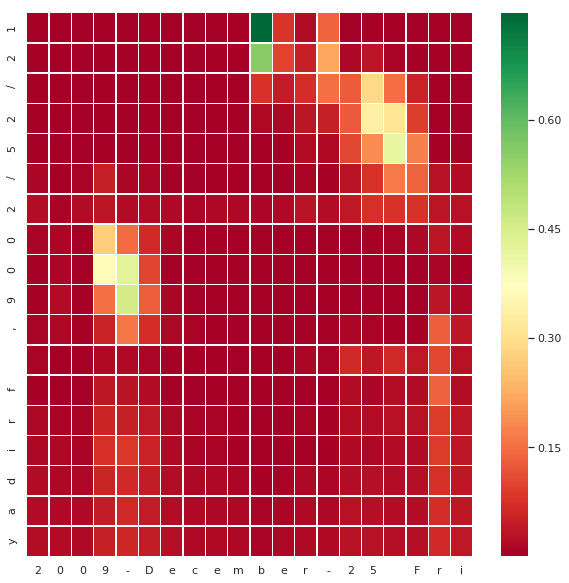

In [38]:
example = [gen_date() for _ in range(1)]
plot_attention(model, example)